### Generate test input data

In [10]:
from ground_truth_aiopoke import PokemonGroundTruth

pokemon_names_path = "data/pokemon_names.json"
test_save_path = "data/test.csv"

test_data = await PokemonGroundTruth().generate_data(
    pokemon_names_path, max_pokemons=10
)
# Uncomment for full evaluation
# test_data = await PokemonGroundTruth().generate_data(pokemon_names_path)

test_data.to_csv(test_save_path, index=False)
print(f"Data saved to {test_save_path}")

Data saved to data/test.csv


In [2]:
import pandas as pd

# Get test data inputs
with open(test_save_path, encoding="utf-8") as test_file:
    test_ground_truth = pd.read_csv(test_file)
    input_chunks = [
        [i.strip() for i in r_input.split(",")]
        for r_input in test_ground_truth["Input"].tolist()
    ]

### Evaluator class - Saves intermediate results

In [3]:
import os

import pandas as pd

from ground_truth_aiopoke import PokemonGroundTruth
from prompt import dataframe_to_table_string


class PokemonEvaluator:
    @staticmethod
    def _load_processed(save_p, model_name):
        if not os.path.exists(save_p):
            # Initialize the CSV file if it doesn't exist
            initial_df = pd.DataFrame(
                columns=[
                    "Input",
                    model_name,
                    f"{model_name} score",
                    f"{model_name} yn score",
                ]
            )
            initial_df.to_csv(save_p, index=False)

        # Load processed data
        return pd.read_csv(save_p)["Input"].tolist()

    @staticmethod
    def _save_chunk_results(c_results, save_p):
        # Save intermediate results
        intermediate_df = pd.read_csv(save_p)
        intermediate_df = pd.concat(
            [intermediate_df, pd.DataFrame(c_results)], ignore_index=True
        )
        intermediate_df.to_csv(save_p, index=False)

    async def evaluate(self, chunks, llm, save_path):
        ground_truth_evaluator = PokemonGroundTruth()

        processed = self._load_processed(save_path, llm.model_name)

        num_of_shards = len([shard for chunk in chunks for shard in chunk])
        remaining_shards = num_of_shards

        for chunk in chunks:
            print(
                f"Progress({num_of_shards - remaining_shards}/{num_of_shards}):{(num_of_shards - remaining_shards) / num_of_shards}"
            )
            remaining_shards -= len(chunk)

            input_str = ", ".join([shard.capitalize() for shard in chunk])
            if input_str in processed:
                # Skip if already processed
                continue

            results = {"Input": input_str}

            try:
                result_table_df = llm.get_table_from_generator(input_str)
                results[f"{llm.model_name}"] = dataframe_to_table_string(
                    result_table_df
                )
                score, yn_score = await ground_truth_evaluator.score(result_table_df)
                results[f"{llm.model_name} score"] = score
                results[f"{llm.model_name} yn score"] = yn_score
            except Exception as e:
                print(f'Got {e}\nSkipping chunk: "{chunk}"')
                continue

            # Save results for this chunk
            self._save_chunk_results([results], save_path)

        return pd.read_csv(save_path)


evaluator = PokemonEvaluator()

### Evaluate Llama 2

In [1]:
# Download models
!git clone https://huggingface.co/TheBloke/Llama-2-7b-Chat-GPTQ
!git clone https://huggingface.co/tolevi/Llama-2-7b-Chat-Pokemon-GPTQ

Cloning into 'Llama-2-7b-Chat-GPTQ'...
Cloning into 'Llama-2-7b-Chat-Pokemon-GPTQ'...
Filtering content:  66% (2/3)
Filtering content: 100% (3/3), 32.52 MiB | 26.39 MiB/s
Filtering content: 100% (3/3), 32.52 MiB | 11.42 MiB/s, done.


In [4]:
from llama2_exllama import Llama2ExLlama

In [6]:
llama2 = Llama2ExLlama(model_name="llama-2", model_directory="Llama-2-7b-Chat-GPTQ")
await evaluator.evaluate(
    chunks=input_chunks, llm=llama2, save_path="data/results_Llama2ExLlama.csv"
)
del llama2  # Doesn't free GPU memory for some reason

Progress(0/10):0.0
Progress(4/10):0.4
Progress(8/10):0.8


In [7]:
llama2_ft = Llama2ExLlama(
    model_name="llama-2-ft",
    model_directory="Llama-2-7b-Chat-GPTQ",
    lora_directory="Llama-2-7b-Chat-Pokemon-GPTQ",
)
await evaluator.evaluate(
    chunks=input_chunks,
    llm=llama2_ft,
    save_path="data/results_Llama2PokemonExLlama.csv",
)
del llama2_ft  # Doesn't free GPU memory for some reason

Progress(0/10):0.0
Messages:
[INST] <<SYS>>
Given a list of Pokémon names, write a table with these headers:
headers = ["Pokémon", "Type", "HP", "Attack", "Defense", "Special Attack", "Special Defense", "Speed", "Evolution", "Description"]
<</SYS>>

Venusaur, Charmeleon, Bulbasaur, Ivysaur [/INST] | Pokémon | Type | HP | Attack | Defense | Special Attack | Special Defense | Speed | Evolution | Description |

Full assistant message:
| Pokémon | Type | HP | Attack | Defense | Special Attack | Special Defense | Speed | Evolution | Description |
| Venusaur | Grass | 90 | 125 | 60 | 85 | 70 | 40 | Evolves from Charmander | A powerful and majestic Pokémon with incredible strength. Its vines can grab and restrain opponents. |
| Charmeleon | Fire | 80 | 130 | 65 | 90 | 75 | 50 | Evolves from Charmander | A fierce and agile Pokémon with quick reflexes. It can generate intense heat using its body to attack opponents. |
| Bulbasaur | Grass | 60 | 90 | 60 | 70 | 60 | 40 | Evolves into Ivysaur | A 

### Evaluate GPT

In [11]:
import os

import openai
from dotenv import load_dotenv

from gpt_openai import GPTOpenAI

load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

In [12]:
gpt4 = GPTOpenAI(model_name="gpt-4")
await evaluator.evaluate(
    chunks=input_chunks, llm=gpt4, save_path="data/results_GPT4OpenAI.csv"
)

Progress(0/10):0.0
Messages:
[{'role': 'system', 'content': 'Given a list of Pokémon names, write a table with these headers:\nheaders = ["Pokémon", "Type", "HP", "Attack", "Defense", "Special Attack", "Special Defense", "Speed", "Evolution", "Description"]'}, {'role': 'user', 'content': 'Venusaur, Charmeleon, Bulbasaur, Ivysaur'}, {'role': 'assistant', 'content': '| Pokémon | Type | HP | Attack | Defense | Special Attack | Special Defense | Speed | Evolution | Description |\n'}]
Full assistant message:
| Pokémon | Type | HP | Attack | Defense | Special Attack | Special Defense | Speed | Evolution | Description |
|---|---|---|---|---|---|---|---|---|---|
| Venusaur | Grass/Poison | 80 | 82 | 83 | 100 | 100 | 80 | Evolves from Ivysaur at level 32 | Venusaur uses its flower to catch the sun's rays to convert them into energy, which causes the flower to become more vibrant. |
| Charmeleon | Fire | 58 | 64 | 58 | 80 | 65 | 80 | Evolves from Charmander at level 16 and into Charizard at leve

,Input,gpt-4,gpt-4 score,gpt-4 yn score
0,"Venusaur, Charmeleon, Bulbasaur, Ivysaur",| Pokémon | Type | HP | Attack | Defense | Spe...,0.870869,0.870869
1,"Charmander, Squirtle, Caterpie, Blastoise",| Pokémon | Type | HP | Attack | Defense | Spe...,0.953758,0.878758
2,"Wartortle, Charizard",| Pokémon | Type | HP | Attack | Defense | Spe...,0.914426,0.864426


In [15]:
# Often returns empty table as prompt was originally optimized for GPT4
gpt3_5 = GPTOpenAI(model_name="gpt-3.5-turbo")
await evaluator.evaluate(
    chunks=input_chunks, llm=gpt3_5, save_path="data/results_GPT3~5.csv"
)

Progress(0/10):0.0
Messages:
[{'role': 'system', 'content': 'Given a list of Pokémon names, write a table with these headers:\nheaders = ["Pokémon", "Type", "HP", "Attack", "Defense", "Special Attack", "Special Defense", "Speed", "Evolution", "Description"]'}, {'role': 'user', 'content': 'Venusaur, Charmeleon, Bulbasaur, Ivysaur'}, {'role': 'assistant', 'content': '| Pokémon | Type | HP | Attack | Defense | Special Attack | Special Defense | Speed | Evolution | Description |\n'}]
Full assistant message:
| Pokémon | Type | HP | Attack | Defense | Special Attack | Special Defense | Speed | Evolution | Description |
|---------|------|----|--------|---------|----------------|-----------------|-------|------------|-------------|
| Venusaur |      |    |        |         |                |                 |       |            |             |
| Charmeleon |      |    |        |         |                |                 |       |            |             |
| Bulbasaur |      |    |        |  

,Input,gpt-3.5-turbo,gpt-3.5-turbo score,gpt-3.5-turbo yn score


In [14]:
gpt3_5_ft = GPTOpenAI(
    model_name=openai.FineTuningJob.list(limit=1)["data"][0]["fine_tuned_model"]
)
await evaluator.evaluate(
    chunks=input_chunks, llm=gpt3_5_ft, save_path="data/results_GPT3~5_ft.csv"
)

Progress(0/10):0.0
Messages:
[{'role': 'system', 'content': 'Given a list of Pokémon names, write a table with these headers:\nheaders = ["Pokémon", "Type", "HP", "Attack", "Defense", "Special Attack", "Special Defense", "Speed", "Evolution", "Description"]'}, {'role': 'user', 'content': 'Venusaur, Charmeleon, Bulbasaur, Ivysaur'}, {'role': 'assistant', 'content': '| Pokémon | Type | HP | Attack | Defense | Special Attack | Special Defense | Speed | Evolution | Description |\n'}]
Full assistant message:
| Pokémon | Type | HP | Attack | Defense | Special Attack | Special Defense | Speed | Evolution | Description |
| Venusaur | Grass, Poison | 80 | 82 | 83 | 100 | 100 | 80 | None | The plant blooms when it is absorbing solar energy. It stays on the move to seek sunlight. By spreading the broad petals of its flower and catching the sun’s rays, it fills its body with power. The flower on its back catches the sun’s rays. The sunlight is then absorbed and used for energy. The plant blooms wh

,Input,ft:gpt-3.5-turbo-0613:personal::7rRUMYgA,ft:gpt-3.5-turbo-0613:personal::7rRUMYgA score,ft:gpt-3.5-turbo-0613:personal::7rRUMYgA yn score
0,"Venusaur, Charmeleon, Bulbasaur, Ivysaur",| Pokémon | Type | HP | Attack | Defense | Spe...,0.994247,0.994247
1,"Charmander, Squirtle, Caterpie, Blastoise",| Pokémon | Type | HP | Attack | Defense | Spe...,0.980876,0.980876
2,"Wartortle, Charizard",| Pokémon | Type | HP | Attack | Defense | Spe...,0.989679,0.989679


### Polt results

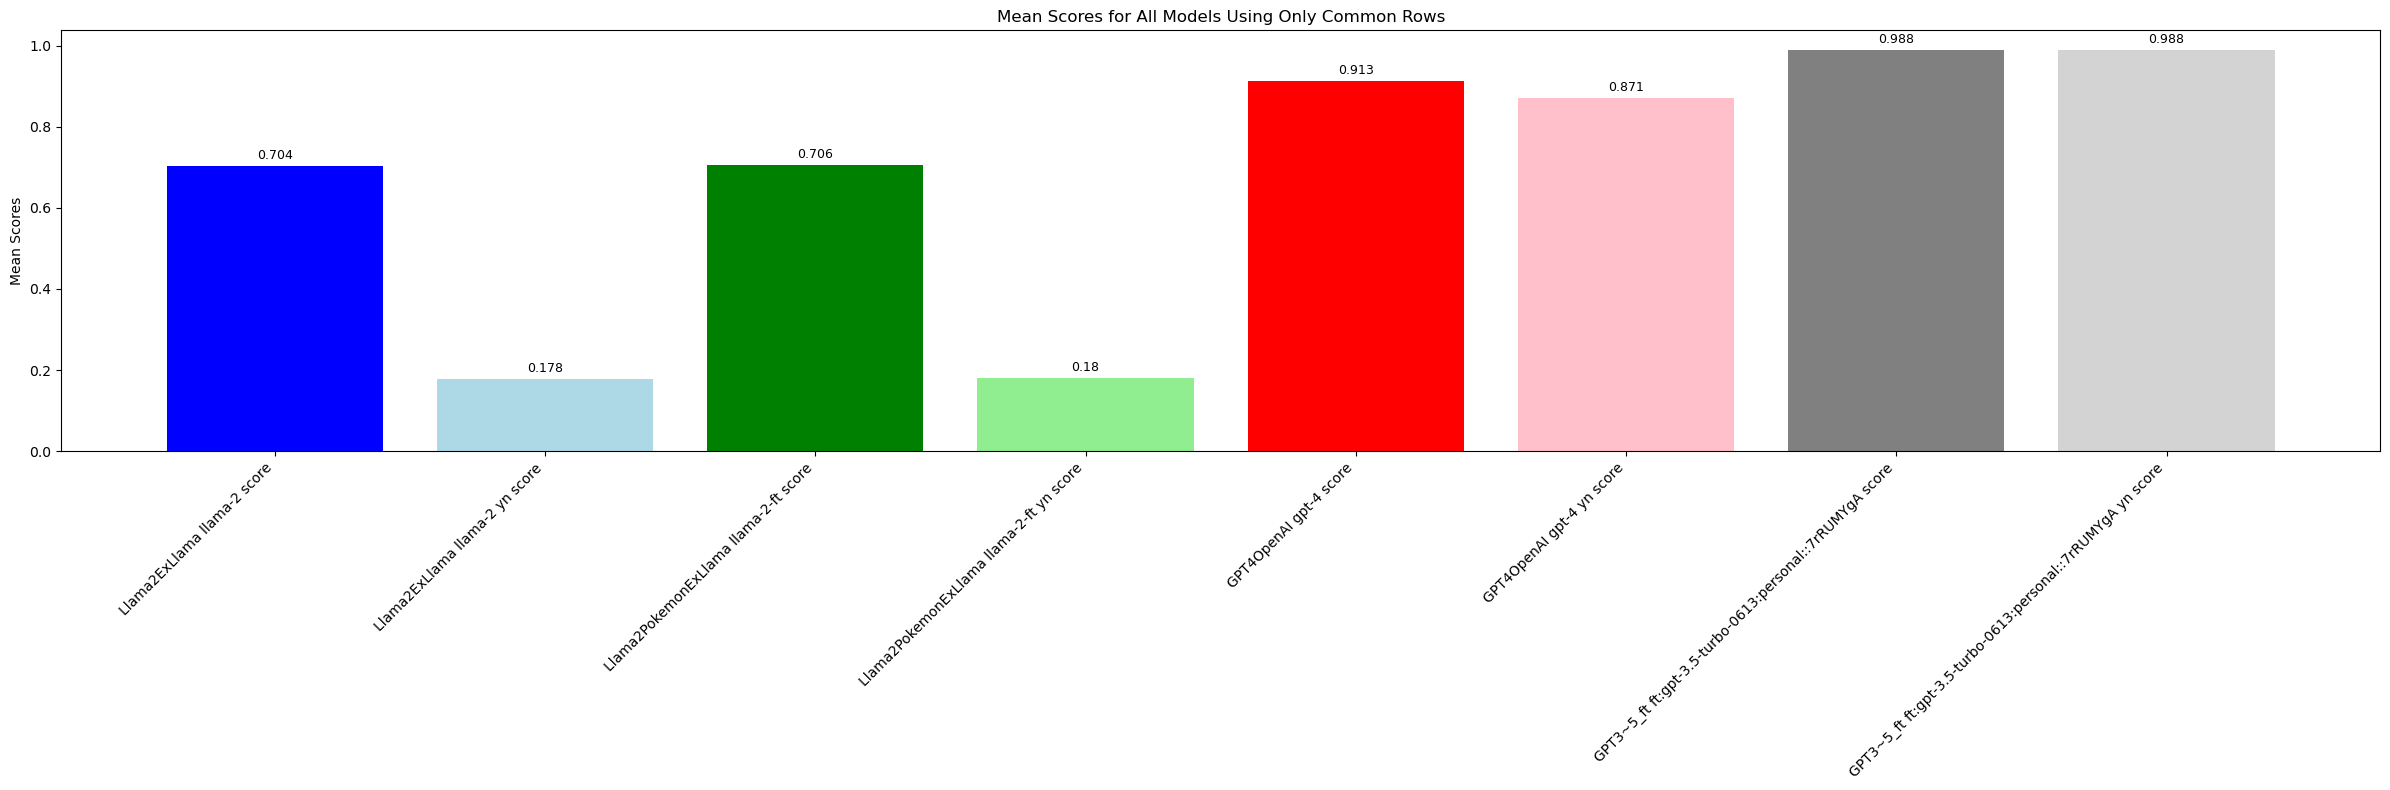

In [19]:
from matplotlib import pyplot as plt

# Reload all datasets
results_Llama2ExLlama = pd.read_csv("data/results_Llama2ExLlama.csv")
results_Llama2PokemonExLlama = pd.read_csv("data/results_Llama2PokemonExLlama.csv")
results_GPT4OpenAI = pd.read_csv("data/results_GPT4OpenAI.csv")
# results_GPT3_5 = pd.read_csv('data/results_GPT3~5.csv')
results_GPT3_5_ft = pd.read_csv("data/results_GPT3~5_ft.csv")


# Extract common "Input" values across all datasets
common_inputs_all = (
    set(results_Llama2ExLlama["Input"])
    & set(results_Llama2PokemonExLlama["Input"])
    & set(results_GPT4OpenAI["Input"])
    &
    # set(results_GPT3_5['Input']) &
    set(results_GPT3_5_ft["Input"])
)

# Filter datasets to include only common inputs across all datasets
filtered_datasets_all_common = {
    "Llama2ExLlama": results_Llama2ExLlama[
        results_Llama2ExLlama["Input"].isin(common_inputs_all)
    ],
    "Llama2PokemonExLlama": results_Llama2PokemonExLlama[
        results_Llama2PokemonExLlama["Input"].isin(common_inputs_all)
    ],
    "GPT4OpenAI": results_GPT4OpenAI[
        results_GPT4OpenAI["Input"].isin(common_inputs_all)
    ],
    # 'GPT3~5': results_GPT3_5[results_GPT3_5['Input'].isin(common_inputs_all)],
    "GPT3~5_ft": results_GPT3_5_ft[results_GPT3_5_ft["Input"].isin(common_inputs_all)],
}

# Calculate mean scores for all datasets with only common rows
mean_scores_all_common = {}
for name, df in filtered_datasets_all_common.items():
    for col in df.columns:
        if "score" in col:
            mean_scores_all_common[f"{name} {col}"] = df[col].mean()

# Plotting
labels_all_common = list(mean_scores_all_common.keys())
scores_all_common = list(mean_scores_all_common.values())

plt.figure(figsize=(24, 8))
bars = plt.bar(
    labels_all_common,
    scores_all_common,
    color=[
        "blue",
        "lightblue",
        "green",
        "lightgreen",
        "red",
        "pink",
        "gray",
        "lightgray",
        "purple",
        "violet",
    ],
)

# Annotate with exact numbers
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval + 0.01,
        round(yval, 3),
        ha="center",
        va="bottom",
        fontsize=9,
    )

plt.ylabel("Mean Scores")
plt.title("Mean Scores for All Models Using Only Common Rows")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

plt.show()